# Flight networks

## Data processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
#import nxviz
#from nxviz import MatrixPlot
from nxviz import CircosPlot

In [3]:
col_names = ['airline','airline_ID','source_airport','source_airport_id','destination_airport','destination_airport_id','codeshare','stops','equipment']
df = pd.read_csv("routes.csv")
df.columns = col_names
print(df.shape)

(67663, 9)


In [4]:
col_names = ['Name', 'City', 'Country', 'IATA', 'ACAO', 'Latitude', 'Longitude', \
             'Altitude', 'Timezone', 'DST', 'Alt_timezone', 'Type', 'Source']

airports = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",\
                      names = col_names)

print(airports.shape)

(7698, 13)


In [5]:
mapping = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")[['name','region']]
airports = airports.merge(mapping, how='left', left_on='Country', right_on='name')

In [6]:
col_names = ['Name', 'City', 'Country', 'IATA', 'ACAO', 'Latitude', 'Longitude', \
             'Altitude', 'Timezone', 'DST', 'Alt_timezone', 'Type', 'Source']

ports = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports-extended.dat",\
                      names = col_names)

print(ports.shape)

(12668, 13)


In [7]:
airports = airports[['Name', 'City', 'Country', 'IATA', 'Latitude', 'Longitude', 'region']]

In [8]:
#df = df.merge(airports, how='left', left_on='source_airport', right_on='IATA')
df = df.merge(airports, how='left', left_on='destination_airport', right_on='IATA')

### EDA

In [9]:
df[['source_airport', 'Name', 'Country']].groupby(['source_airport', 'Name']).count().sort_values(by='Country', ascending=False).head(10)

,,Country
source_airport,Name,
ORD,Hartsfield Jackson Atlanta International Airport,20
ATL,Chicago O'Hare International Airport,19
HKT,Suvarnabhumi Airport,13
ORD,Louis Armstrong New Orleans International Airport,13
ATL,Miami International Airport,12
HKG,Suvarnabhumi Airport,12
AUH,Muscat International Airport,12
MIA,Hartsfield Jackson Atlanta International Airport,12
CAN,Hangzhou Xiaoshan International Airport,12


In [10]:
df[['destination_airport', 'Country']].groupby(['destination_airport']).count().sort_values(by='Country', ascending=False).head(10)

,Country
destination_airport,
ATL,911
ORD,550
PEK,534
LHR,524
CDG,517
LAX,498
FRA,493
DFW,467
JFK,455


### Country analysis

In [11]:
T = nx.from_pandas_edgelist(df, 'source_airport', 'destination_airport')

In [12]:
print(type(T))
print("Node count: " + str(len(T.nodes())))
print("Edge count: " + str(len(T.edges())))

<class 'networkx.classes.graph.Graph'>
Node count: 3425
Edge count: 19257


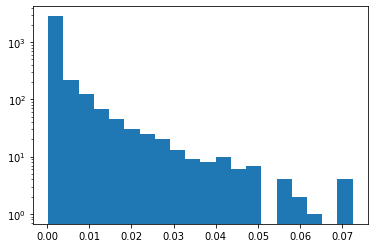

In [13]:
# Distribution of centrality

dcs = nx.degree_centrality(T)
user_dcs = [dcs[n] for n in T.nodes()]
plt.yscale('log')
plt.hist(user_dcs, bins=20)
plt.show()

### Network visuals

In [14]:
def spider_plot(ctry):
    fig, ax = plt.subplots(figsize=(20,20))
    country_net =nx.from_pandas_edgelist(df[df.Country == ctry], 'source_airport', 'destination_airport')
    ordered = pd.DataFrame(list(country_net.nodes()), columns = ['IATA']).merge(airports, how='left', on='IATA').set_index('IATA')

    dcs = nx.degree_centrality(country_net)
    for n in country_net.nodes():
        country_net.node[n]['centrality'] = dcs[n]
        country_net.node[n]['country'] = ordered.Country.to_dict()[n]
        country_net.node[n]['latitude'] = ordered.Latitude.to_dict()[n]
        country_net.node[n]['longitude'] = ordered.Longitude.to_dict()[n]
        country_net.node[n]['region'] = ordered.region.to_dict()[n]

    nx.draw_networkx(country_net, with_labels=True,node_size=250,font_size=8, style='dashed', alpha=0.8)
    
    return country_net

C:\Users\Mike\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


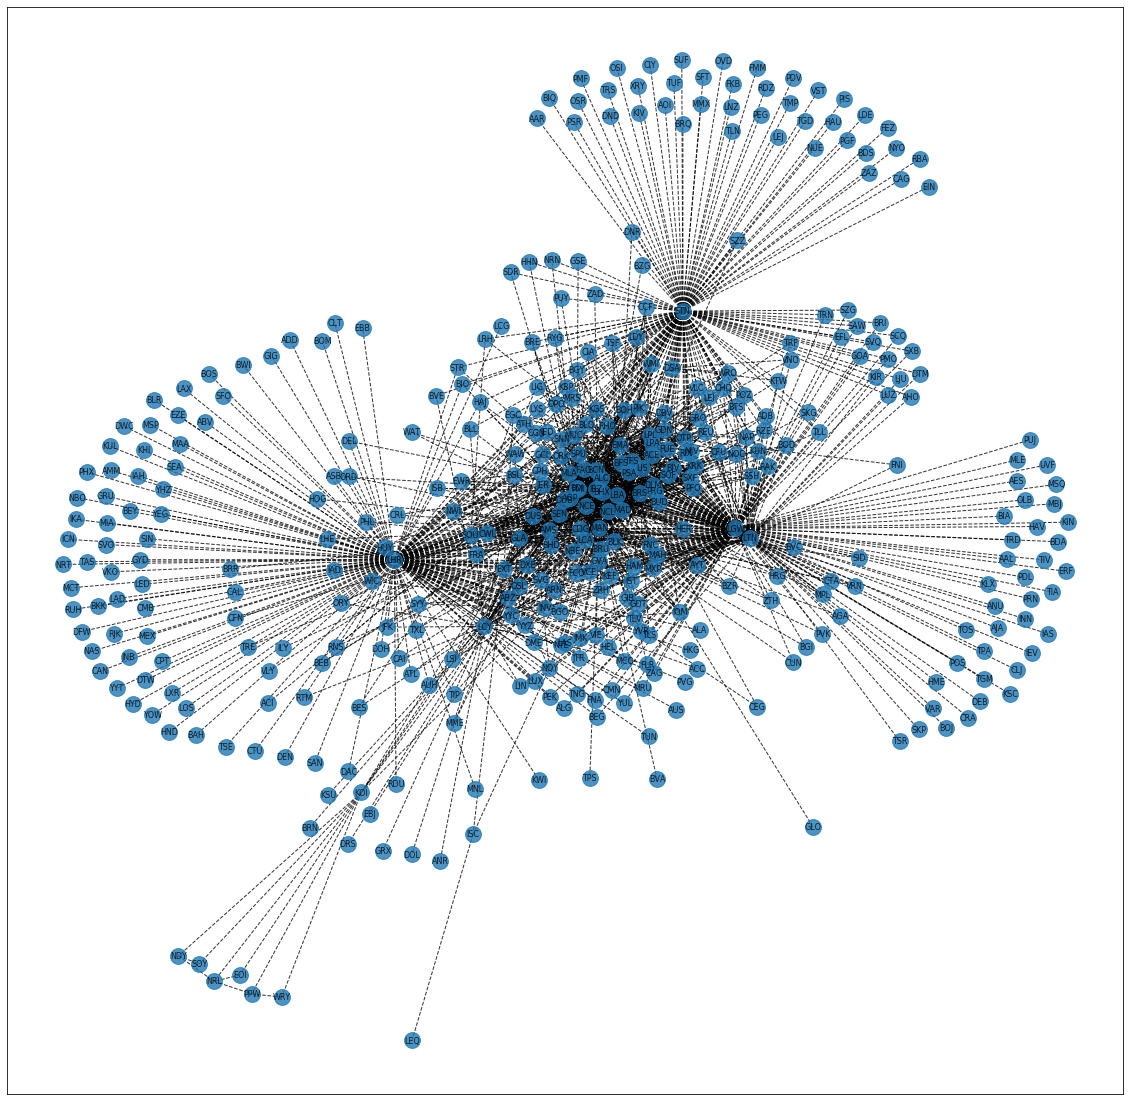

In [15]:
spider_plot('United Kingdom')

In [16]:
#c = CircosPlot(country_net)
#c.draw()
#plt.show()

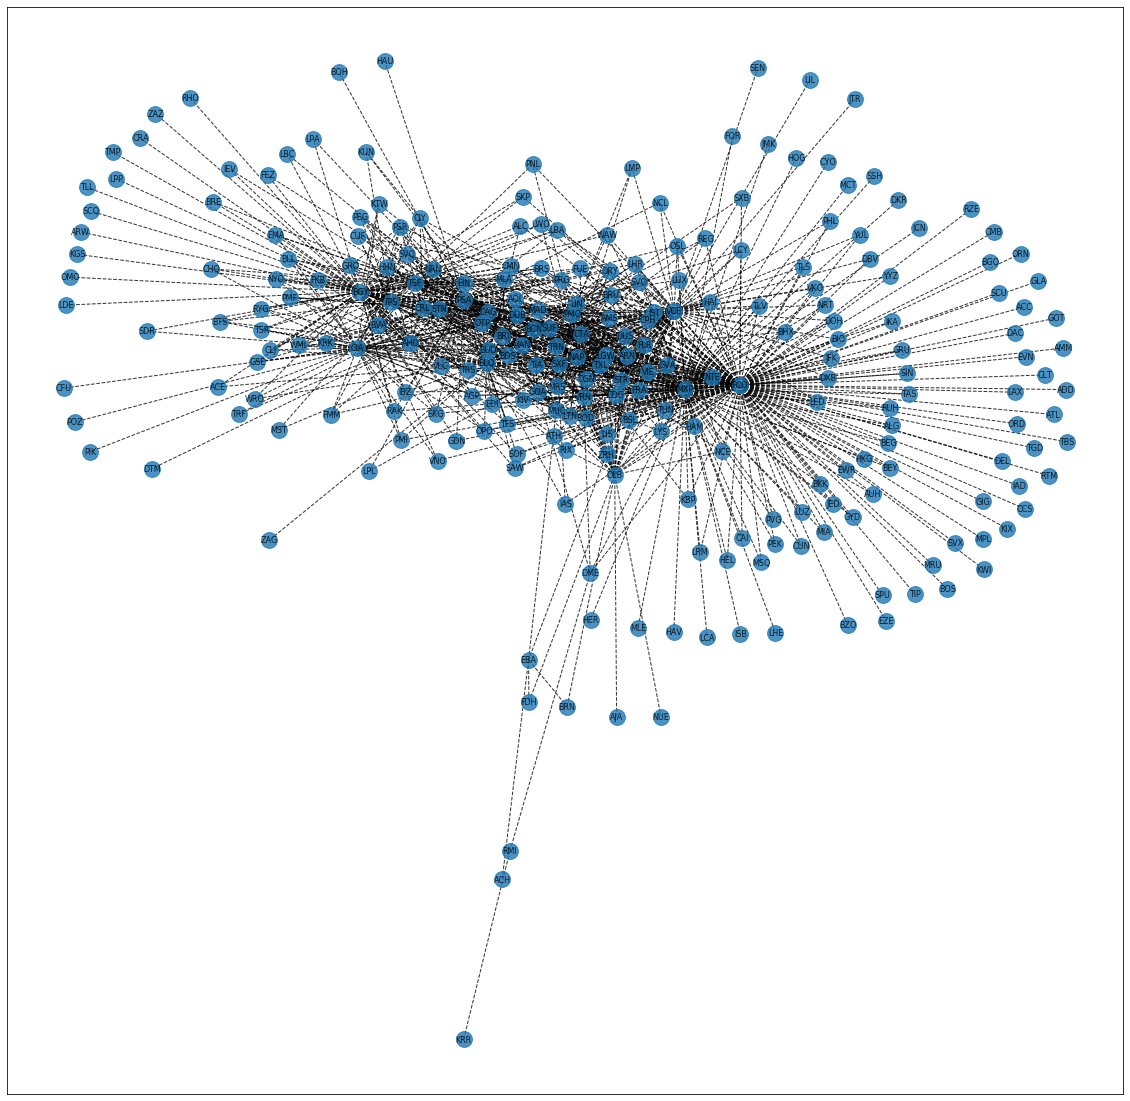

In [17]:
spider_plot('Italy')

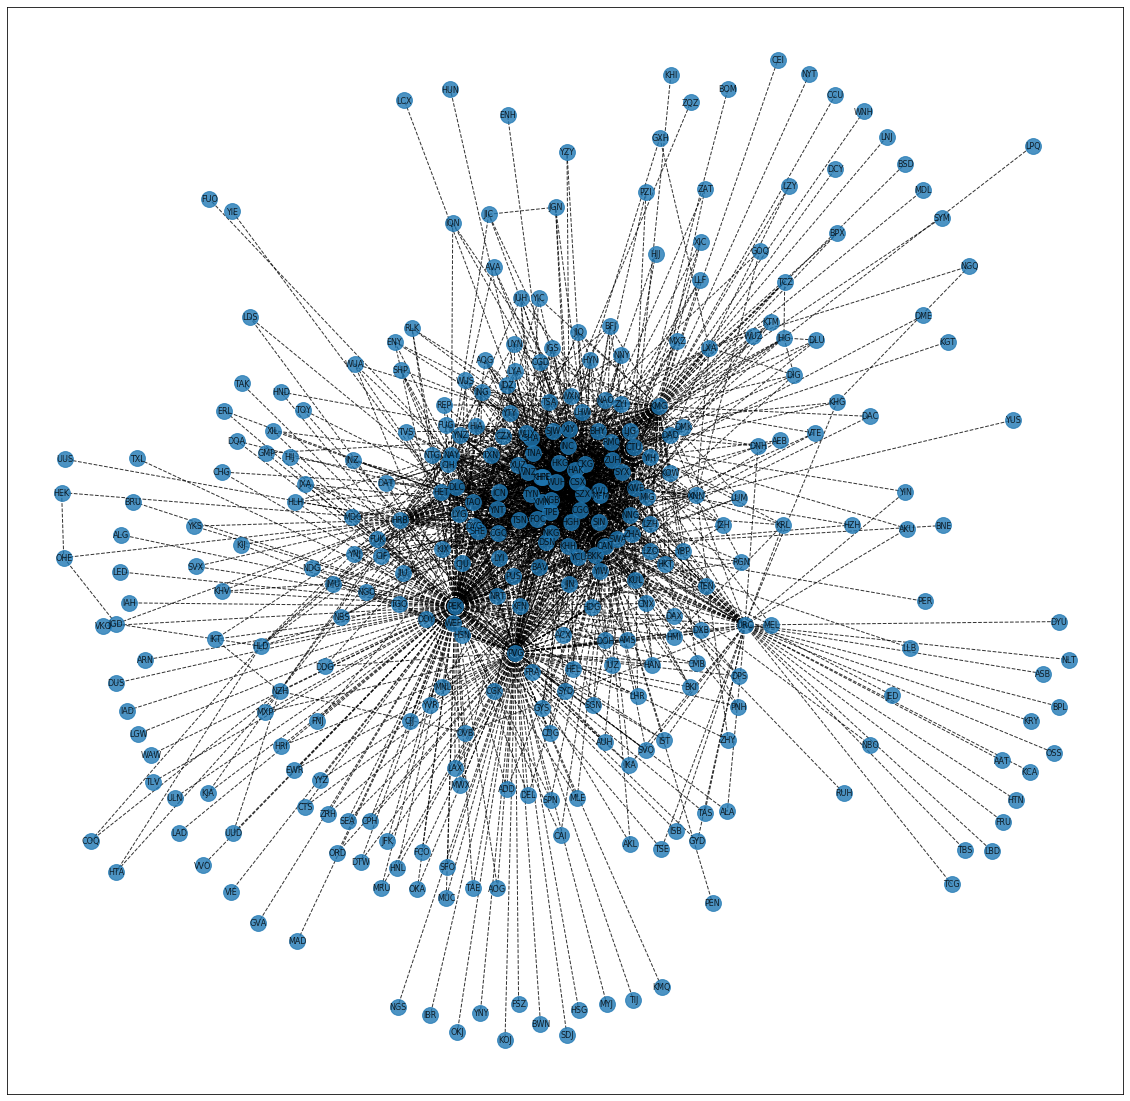

In [18]:
spider_plot('China')

### Centrality measures

In [19]:
deg_cent = nx.degree_centrality(T)
max_dc = max(deg_cent.values())
central_airports = [n for n, dc in deg_cent.items() if dc == max_dc]
airports[airports.IATA.isin(central_airports)]

,Name,City,Country,IATA,Latitude,Longitude,region
574,Amsterdam Airport Schiphol,Amsterdam,Netherlands,AMS,52.308601,4.76389,Europe


### Cliques

In [20]:
cliques = nx.find_cliques(T)

In [21]:
list(cliques)

[['ZYL', 'LHR', 'DAC', 'AUH'],
 ['ZYL', 'LHR', 'DAC', 'DXB'],
 ['LUD', 'WDH', 'OMD'],
 ['LKO', 'DEL', 'BOM', 'DXB', 'RUH', 'BLR', 'MCT', 'JED'],
 ['LKO', 'DEL', 'BOM', 'PAT'],
 ['LKO', 'DEL', 'DED'],
 ['DAU', 'POM', 'UNG'],
 ['DAU', 'POM', 'LAE'],
 ['IRJ', 'AEP'],
 ['BFJ', 'SHA', 'CKG', 'CAN', 'KWE', 'KMG'],
 ['BFJ', 'SHA', 'CKG', 'CAN', 'NAY'],
 ['BFJ', 'SHA', 'CKG', 'SZX', 'KWE', 'KMG'],
 ['BFJ', 'SHA', 'CKG', 'SZX', 'NAY'],
 ['SEZ', 'PRI'],
 ['SEZ', 'FRA', 'CMB', 'AUH'],
 ['SEZ', 'FRA', 'CMB', 'DXB'],
 ['SEZ', 'FRA', 'VKO', 'MRU'],
 ['SEZ', 'FRA', 'NBO', 'JNB', 'AUH'],
 ['SEZ', 'FRA', 'NBO', 'JNB', 'MRU', 'DXB'],
 ['SNE', 'VXE', 'SID'],
 ['BKO', 'CDG', 'CMN', 'DKR', 'LIS', 'TUN', 'ALG'],
 ['BKO', 'CDG', 'CMN', 'DKR', 'NKC', 'TUN'],
 ['BKO', 'CDG', 'CMN', 'DKR', 'NKC', 'CKY'],
 ['BKO', 'CDG', 'CMN', 'DKR', 'ABJ', 'OUA', 'TUN', 'ALG'],
 ['BKO', 'CDG', 'CMN', 'DKR', 'ABJ', 'OUA', 'COO'],
 ['BKO', 'CDG', 'CMN', 'DKR', 'ABJ', 'LOS', 'COO'],
 ['BKO', 'CDG', 'CMN', 'DKR', 'ABJ', 'CKY'],
 [